In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

In [ ]:
import vk

In [ ]:
login = '' # логин/номер телефона
password = '' # пароль
vk_id = '' # id приложения vk

v = '5.126'

In [ ]:
session = vk.AuthSession(app_id=vk_id, user_login=login, user_password=password) 
vkapi = vk.API(session, v=v)

In [ ]:
# функция для получения участников сообщества

def get_members(id_group, count_m=5000):    
    for offset_number in range(0, count_m, 1000):
        time.sleep(0.15)
        data = vkapi.groups.getMembers(group_id=id_group, fields='sex, bdate, city, country', offset=offset_number, count=1000)
        for i in data['items']:
            list_of_members.append(i)
        
    return list_of_members

# Получим 5000 участников сообщества, посвященного В. Маяковскому – vk.com/public27179774
list_of_members = []
group_members = get_members(27179774)

# создадим фрейм данных
group_members_df = pd.DataFrame(group_members)

In [ ]:
group_members_df

,first_name,id,last_name,can_access_closed,is_closed,sex,bdate,city,country,deactivated
0,Александр,17,Беспалов,True,False,2,21.10.1982,Санкт-Петербург,Россия,NaN
1,Александра,1025,Подзоров,NaN,NaN,1,NaN,не указано,не указано,banned
2,Алёна,1131,Сколкова,NaN,NaN,1,NaN,не указано,не указано,banned
3,Виктория,1132,Макаров,NaN,NaN,1,NaN,не указано,не указано,banned
4,Alex,1351,Demidovich,True,False,2,27.4.1989,Санкт-Петербург,Россия,NaN
...,...,...,...,...,...,...,...,...,...,...
4995,Алина,3007087,Окорокова,True,False,1,24.3,Москва,Россия,NaN
4996,Виктория,3007243,Косенко,True,False,1,16.6.1989,не указано,не указано,NaN
4997,Валентина,3008178,Уварова,True,False,1,1.4.1986,Великий Новгород,Россия,NaN
4998,DELETED,3008500,,NaN,NaN,1,NaN,не указано,не указано,deleted


In [ ]:
# удалим забаненных пользователей

group_members_df = group_members_df[group_members_df['deactivated'] != 'banned']
group_members_df.drop('deactivated', axis=1, inplace=True)

In [ ]:
# оставим в столбцах города и страны только их id

city = []
country = []

for i in group_members_df['city'].fillna('не указано'):
    if i != 'не указано':
        city.append(i['title'])
    else:
        city.append('не указано')

for i in group_members_df['country'].fillna('не указано'):
    if i != 'не указано':
        country.append(i['title'])
    else:
        country.append('не указано')

group_members_df['city'] = city
group_members_df['country'] = country

In [ ]:
# объединим имя и фамилию пользователя

group_members_df['name'] = group_members_df['first_name'] + ' '+ group_members_df['last_name']
group_members_df.drop(['first_name', 'last_name'], axis=1, inplace=True)

In [ ]:
# разобъем дату рождения на день, месяц и год и оставим только год

bd = group_members_df['bdate'].str.split('.',expand=True)
bd.columns=['bday', 'bmonth', 'byear']
group_members_df = pd.concat([group_members_df,bd], axis=1)
group_members_df.drop(['bdate', 'bday', 'bmonth'], axis=1, inplace=True)

In [ ]:
# заполним пустые значения нулем

group_members_df.fillna(0, inplace=True)

In [ ]:
group_members_df

,id,can_access_closed,is_closed,sex,city,country,name,byear
0,17,True,False,2,Санкт-Петербург,Россия,Александр Беспалов,1982
4,1351,True,False,2,Санкт-Петербург,Россия,Alex Demidovich,1989
6,2195,False,True,2,Санкт-Петербург,Россия,Станислав Давыдов,1989
7,2322,True,False,1,0,0,Nadia Mariani,0
8,3762,True,False,1,Москва,Россия,Анастасия Попова,1987
...,...,...,...,...,...,...,...,...
4995,3007087,True,False,1,Москва,Россия,Алина Окорокова,0
4996,3007243,True,False,1,0,0,Виктория Косенко,1989
4997,3008178,True,False,1,Великий Новгород,Россия,Валентина Уварова,1986
4998,3008500,0,0,1,0,0,DELETED,0


In [ ]:
# приведем значения города, пола и года к числовому типу

group_members_df[['city', 'country', 'byear']] = group_members_df[['city', 'country', 'byear']].astype(int)

In [ ]:
# изменим порядок столбцов, исключим удаленные аккаунты

group_members_df = group_members_df[['id', 'name', 'sex', 'byear', 'city', 'country']]
group_members_df = group_members_df[group_members_df['name'] != 'DELETED ']

In [ ]:
group_members_df.reset_index(drop=True)
group_members_df.rename(columns={'name': 'label'}, inplace=True)

In [ ]:
# для удобства сохраним список id участников сообщества в отдельную переменную

members_ids = list(group_members_df['id'])

In [ ]:
# напишем функцию, которая по id пользователя возвращает список id его
# друзей, состоящих в исследуемом сообществе

def user_friends(vkid, count_f=5000):
    try:
        data = vkapi.friends.get(user_id=vkid, count=count_f)['items']
    except: 
        return []
    
    friends_inside_community = list(set(data).intersection(members_ids))
    return friends_inside_community

In [ ]:
# построим связи между ползователями сообщества
# cоздаем файл и сохраним в нем список ребер

id = []
target = []

f1 = open('friends_inside_1.txt', 'w')

pbar = tqdm.tqdm(members_ids, position=0, leave=True)
for member_id in members_ids:
    time.sleep(0.15)
    a = user_friends(member_id)
    
    if len(a) != 0:
        for friend_id in a:
            id.append(member_id)
            target.append(friend_id)

    pbar.update(1)
pbar.close()


edges = pd.DataFrame({'Source':id, 'Target': target})

100%|██████████| 4555/4555 [34:55<00:00,  2.17it/s]


In [ ]:
edges

,Source,Target
0,17,1587067
1,17,238238
2,2322,1457745
3,2322,2818498
4,4859,2635269
...,...,...
4104,3011076,587144
4105,3011076,261236
4106,3011076,2519227
4107,3011076,858332


In [ ]:
# так, как многие страницы vk закрыты (что не позволяет получить список друзей),
# оставляем в фрейме данных только те значения, для которых удалось собрать данные о друзьях

for i in group_members_df['id']:
    if i not in list(edges['Source']):
        group_members_df = group_members_df[group_members_df['id'] != i] 

In [ ]:
group_members_df

,id,label,sex,byear,city,country
0,17,Александр Беспалов,2,1982,2,1
7,2322,Nadia Mariani,1,0,0,0
12,4859,Надежда Морозова,1,1989,0,0
16,5765,Liska Inoplanetnaya,1,0,99,1
17,5769,Ирина Бармина,1,0,2,1
...,...,...,...,...,...,...
4985,3003976,Кассандра Скарлат,1,0,1,1
4988,3004413,Андрей Базанов,2,0,2,1
4989,3004708,Эмилия Сафиева,1,0,1,1
4991,3006857,Мария Прохорова,1,0,1,1


In [ ]:
# сохраним таблицы ребер и вершин для последующей работы в gephi

group_members_df.to_csv('nodes.csv', index = False, sep = ';', encoding='utf-8')
edges.to_csv('edges.csv', index = False, sep = ';', encoding='utf-8')

In [ ]:
df = pd.read_excel('vk.xlsx')

In [ ]:
df[df['byear'] != 'не указано']['byear'].astype(int)

0       1902
1       1902
2       1903
3       1903
4       1904
        ... 
1673    2006
1674    2006
1675    2006
1676    2006
1677    2006
Name: byear, Length: 1678, dtype: int64

In [ ]:
df

,id,label,sex,byear,age,city,country
0,2409648,Божена Суворова,жен,1902,118,Екатеринбург,Россия
1,2916226,Анастасия Травчук,жен,1902,118,Краснодар,Россия
2,334378,Лукьян Барсуков,муж,1903,117,не указано,Россия
3,1079011,Оксана Оксана,жен,1903,117,Москва,Россия
4,1606859,Гатя Колубева,жен,1904,116,Санкт-Петербург,Россия
...,...,...,...,...,...,...,...
4550,3006857,Мария Прохорова,жен,не указано,не указано,Москва,Россия
4551,3007087,Алина Окорокова,жен,не указано,не указано,Москва,Россия
4552,3011076,Александр Кипсоне,муж,не указано,не указано,не указано,Россия
4553,3011533,Евгений Качалков,муж,не указано,не указано,Екатеринбург,Россия


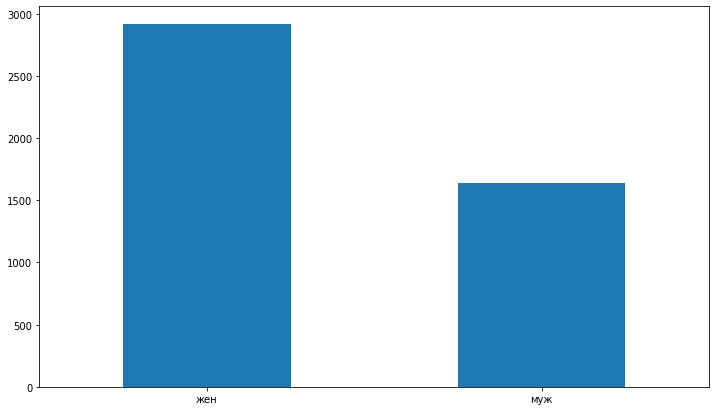

In [ ]:
plt.figure(figsize=(12, 7))
df['sex'].value_counts().plot(kind='bar')
plt.tick_params(axis = 'x', labelrotation = 0)

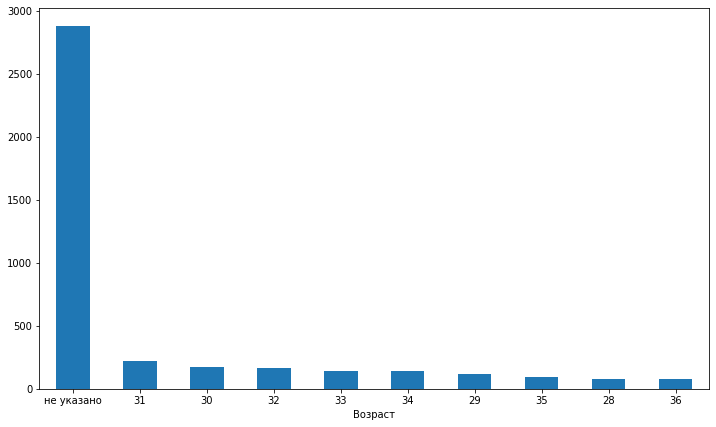

In [ ]:
plt.figure(figsize=(12, 7))
df['age'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Возраст')
plt.tick_params(axis = 'x', labelrotation = 0)

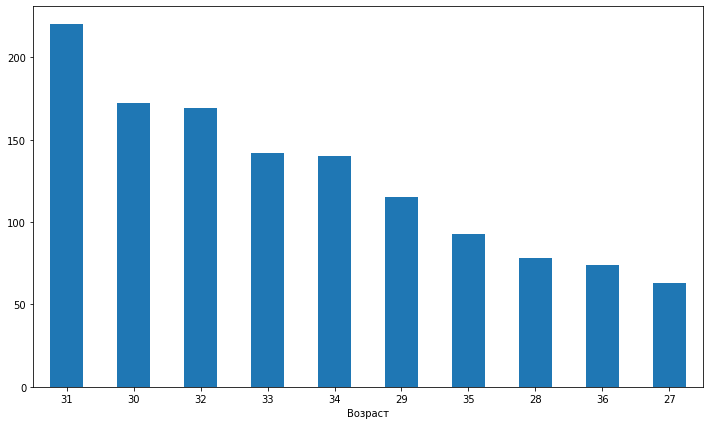

In [ ]:
plt.figure(figsize=(12, 7))
df[df['age'] != 'не указано']['age'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Возраст')
plt.tick_params(axis = 'x', labelrotation = 0)

In [ ]:
df[df['byear'] != 'не указано']['byear'].astype(int).max()

2006

In [ ]:
df[df['byear'] != 'не указано']['byear'].astype(int).min()

1902

In [ ]:
df[(df['byear'] != 'не указано') & (df[df['byear'] != 'не указано']['byear'].astype(int) > 1950)]['byear'].min()

1952

In [ ]:
df[df['age'] != 'не указано']['age'].max()

118

In [ ]:
df[df['age'] != 'не указано']['age'].min()

14

In [ ]:
int(df[df['age'] != 'не указано']['age'].mean())

34

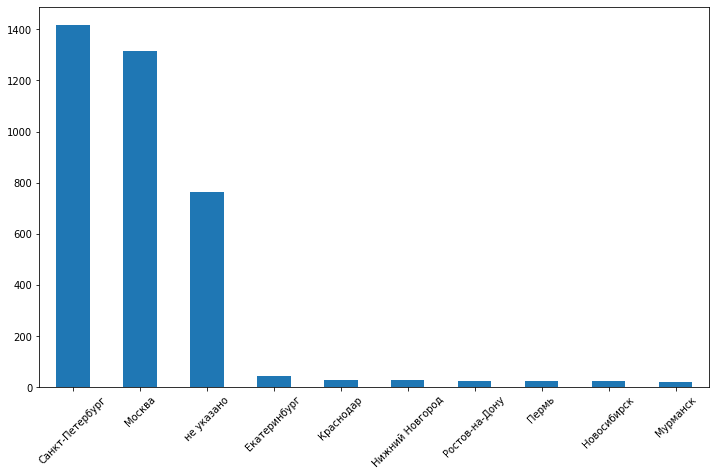

In [ ]:
plt.figure(figsize=(12, 7))
df['city'].value_counts().head(10).plot(kind='bar')
plt.tick_params(axis = 'x', labelrotation = 45)

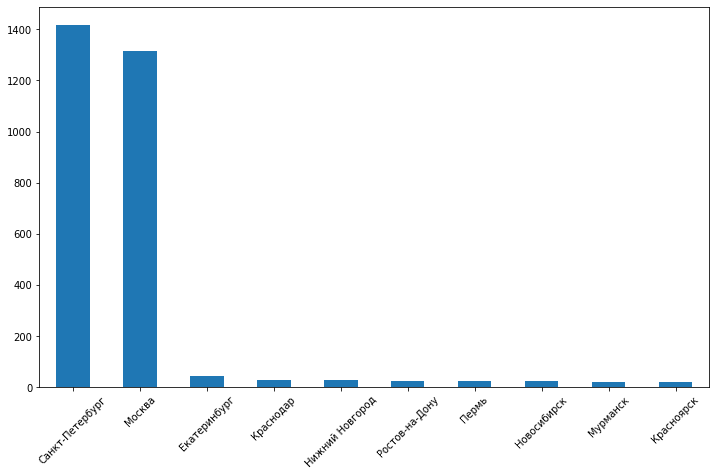

In [ ]:
plt.figure(figsize=(12, 7))
df[df['city'] != 'не указано']['city'].value_counts().head(10).plot(kind='bar')
plt.tick_params(axis = 'x', labelrotation = 45)

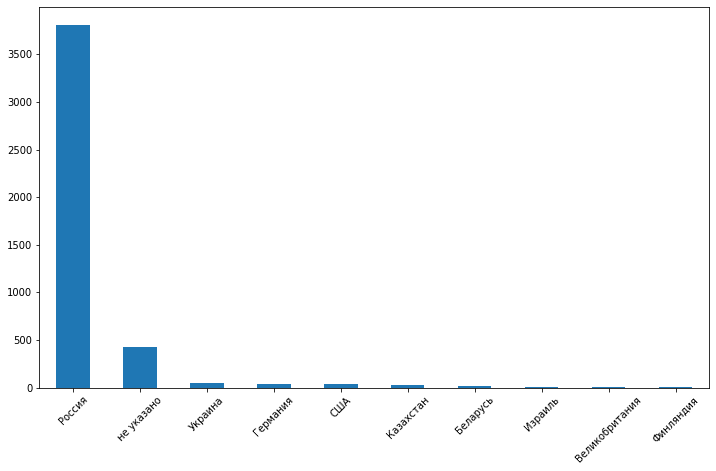

In [ ]:
plt.figure(figsize=(12, 7))
df['country'].value_counts().head(10).plot(kind='bar')
plt.tick_params(axis = 'x', labelrotation = 45)

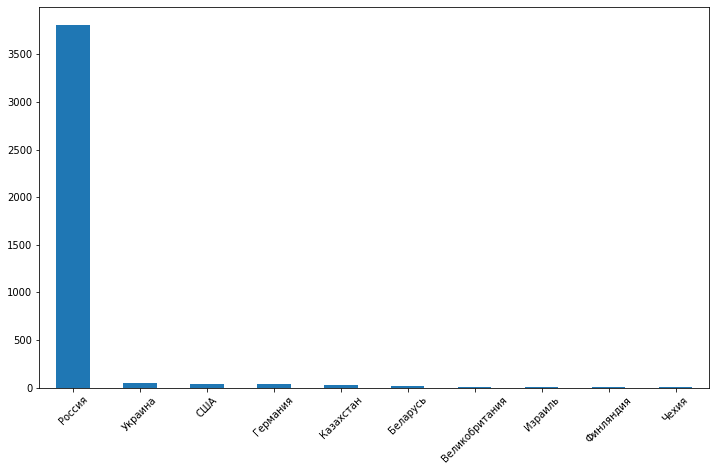

In [ ]:
plt.figure(figsize=(12, 7))
df[df['country'] != 'не указано']['country'].value_counts().head(10).plot(kind='bar')
plt.tick_params(axis = 'x', labelrotation = 45)